# first attempts at autogluon

our first attempt is just to get an idea of how autogluon works. we'll be doing a relatively simple prediction: given the daily frequency of crimes for a time period, predict future daily crime frequencies. namely, given the daily frequence of crimes for the previous few months, predict the next week's daily crime frequencies.

In [1]:
import pandas as pd
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

we read `crime.csv`, montgomery county's crime data, and group all the crimes that were committed in one day together. we remember to filter out data with no dates attached to them, and also get rid the columns we don't need, which amounts to almost every single one of them.

In [2]:
df = pd.read_csv("../crime.csv")
df = df[df['Start_Date_Time'] != '']
df['Start_Date_Time'] = df['Start_Date_Time'].str[:10]
df['target'] = 1
df = df[df.columns.intersection(['Start_Date_Time','target'])]
df = df.groupby(['Start_Date_Time'],sort=False,as_index=False).sum()
df['crime'] = 'Crimes'
df['Start_Date_Time'] = pd.to_datetime(df['Start_Date_Time'])
# df = df[df['Start_Date_Time'] >= pd.to_datetime('2022-01-01')]
df = df[df['Start_Date_Time'] <= pd.to_datetime('2023-01-01')]
df = df.sort_values(by='Start_Date_Time')
df.tail()

/tmp/ipykernel_1786967/226934276.py:1: DtypeWarning: Columns (1,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../crime.csv")


,Start_Date_Time,target,crime
1532,2022-12-28,130,Crimes
1316,2022-12-29,137,Crimes
1322,2022-12-30,138,Crimes
1347,2022-12-31,108,Crimes
1567,2023-01-01,125,Crimes


In [3]:
from scipy import stats
from pandas.tseries.holiday import USFederalHolidayCalendar

known_covariates_per_item = pd.DataFrame()
df['bc_target'] = stats.boxcox(df['target'])[0]
known_covariates_per_item['weekend'] = df['Start_Date_Time'].dt.dayofweek // 5
holidays = USFederalHolidayCalendar().holidays(start='2015-01-01', end='2023-01-31').to_pydatetime()
known_covariates_per_item['holiday'] = [1 if d in holidays else 0 for d in df['Start_Date_Time']]
known_covariates_per_item['timestamp'] = df['Start_Date_Time']
known_covariates_per_item['item_id'] = 'Crimes'
known_covariates = TimeSeriesDataFrame(known_covariates_per_item)
known_covariates.head()

weekend  holiday
item_id timestamp                   
Crimes  2016-07-01        0        0
        2016-07-02        1        0
        2016-07-03        1        0
        2016-07-04        0        1
        2016-07-05        0        0

In [4]:
train_data = TimeSeriesDataFrame.from_data_frame(df, id_column='crime', timestamp_column='Start_Date_Time')
train_data.head()

target  bc_target
item_id timestamp                    
Crimes  2016-07-01     243  40.962081
        2016-07-02     175  33.494902
        2016-07-03     152  30.704962
        2016-07-04     125  27.195350
        2016-07-05     167  32.542749

In [14]:
predictor = TimeSeriesPredictor(
    prediction_length = 60, 
    path = './basic_total_crimes', 
    target = 'target',
    known_covariates=known_covariates, 
    eval_metric = 'sMAPE',
)
predictor.fit(train_data, num_cpus=16, num_gpus=4, presets='best_quality')

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: best_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'sMAPE',
 'hyperparameter_tune_kwargs': {'num_trials': 10,
                                'scheduler': 'local',
                                'searcher': 'auto'},
 'hyperparameters': 'best_quality',
 'num_cpus': 16,
 'num_gpus': 4,
 'prediction_length': 60,
 'random_seed': None,
 'target': 'target',
 'time_limit': None}
Provided training data set with 2376 rows, 1 items (item = single time series). Average time series length is 2376.0.
Training artifacts will be saved to: /fs/cml-projects/teamgahsp/gahsp/basic_total_crimes
AutoGluon will save models to ./basic_total_crimes/
AutoGluon will gauge predictive performance using evaluation metric: 'sMAPE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Pr

  0%|          | 0/10 [00:00<?, ?it/s]

Stopping HPO due to exhausted search space: 2 of 2 possible configs ran.
	Trained 2 models while tuning Theta.
	-0.1397       = Validation score (-sMAPE)
	10.64   s     = Total tuning time
Hyperparameter tuning model: ARIMA. 
	-0.1393       = Validation score (-sMAPE)
	0.00    s     = Training runtime
	5.51    s     = Validation (prediction) runtime
Hyperparameter tuning model: AutoETS. 
	-0.1396       = Validation score (-sMAPE)
	0.00    s     = Training runtime
	3.56    s     = Validation (prediction) runtime
Hyperparameter tuning model: DynamicOptimizedTheta. 
	-0.1345       = Validation score (-sMAPE)
	0.00    s     = Training runtime
	12.31   s     = Validation (prediction) runtime
Hyperparameter tuning model: DeepAR. 


  0%|          | 0/10 [00:00<?, ?it/s]

	Trained 10 models while tuning DeepAR.
	-0.1208       = Validation score (-sMAPE)
	836.00  s     = Total tuning time
Hyperparameter tuning model: AutoARIMA. 
	-0.1403       = Validation score (-sMAPE)
	0.00    s     = Training runtime
	1.04    s     = Validation (prediction) runtime
Hyperparameter tuning model: TemporalFusionTransformer. 
	-0.1109       = Validation score (-sMAPE)
	277.10  s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Hyperparameter tuning model: SimpleFeedForward. 


  0%|          | 0/10 [00:00<?, ?it/s]

Stopping HPO due to exhausted search space: 3 of 3 possible configs ran.
	Trained 3 models while tuning SimpleFeedForward.
	-0.1221       = Validation score (-sMAPE)
	156.41  s     = Total tuning time
Fitting simple weighted ensemble.
	-0.1084       = Validation score (-sMAPE)
	7.90    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training complete. Models trained: ['Naive', 'SeasonalNaive', 'ETS', 'Theta/T1', 'Theta/T2', 'ARIMA', 'AutoETS', 'DynamicOptimizedTheta', 'DeepAR/T1', 'DeepAR/T2', 'DeepAR/T3', 'DeepAR/T4', 'DeepAR/T5', 'DeepAR/T6', 'DeepAR/T7', 'DeepAR/T8', 'DeepAR/T9', 'DeepAR/T10', 'AutoARIMA', 'TemporalFusionTransformer', 'SimpleFeedForward/T1', 'SimpleFeedForward/T2', 'SimpleFeedForward/T3', 'WeightedEnsemble']
Total runtime: 1333.20 s
Best model: WeightedEnsemble
Best model score: -0.1084


In [15]:
predictions = predictor.predict(train_data)
predictions.head()

[rank: 0] Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                    
Crimes  2023-01-02  130.317215  113.990402  121.213562  123.879776   
        2023-01-03  131.402832  112.377121  120.371536  124.638741   
        2023-01-04  130.862000  110.970032  118.468414  123.791756   
        2023-01-05  130.833069  112.259338  118.840408  124.109718   
        2023-01-06  130.501740  113.000824  119.075005  123.638550   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
Crimes  2023-01-02  127.400208  130.317215  133.537659  136.314896   
        2023-01-03  127.514870  131.402832  134.264252  137.633163   
        2023-01-04  127.137558  130.862000  134.215042  138.417145   
        2023-01-05  127.742043  130.833069  134.650208  138.892761   
        2023-01-06  127.941025  130.501740  134.818542  138.397980   

                           0.8         0.9  
item_id timestamp                           
Crimes  2023-01-02  139.532516  145.979477  
        2023-01-03  141.851959  148.212570  
        2023-01-04  142.865021  148.507538  
        2023-01-05  142.935974  148.214874  
        2023-01-06  142.657990  147.324402

In [29]:
import matplotlib.pyplot as plt

test_data = pd.read_csv("../crime.csv")
test_data = test_data[test_data['Start_Date_Time'] != '']
test_data['Start_Date_Time'] = test_data['Start_Date_Time'].str[:10]
test_data['target'] = 1
test_data = test_data[test_data.columns.intersection(['Start_Date_Time','target'])]
test_data = test_data.groupby(['Start_Date_Time'],sort=False,as_index=False).sum()
test_data['crime'] = 'Crimes'
test_data['Start_Date_Time'] = pd.to_datetime(test_data['Start_Date_Time'])
test_data = test_data.sort_values(by='Start_Date_Time')
test_data = test_data[test_data['Start_Date_Time'] >= pd.to_datetime('2022-01-01')]
test_data = test_data[test_data['Start_Date_Time'] <= pd.to_datetime('2023-03-31')]
test_data = TimeSeriesDataFrame.from_data_frame(test_data, id_column='crime', timestamp_column='Start_Date_Time')

/tmp/ipykernel_1786967/2365362555.py:3: DtypeWarning: Columns (1,18) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv("../crime.csv")


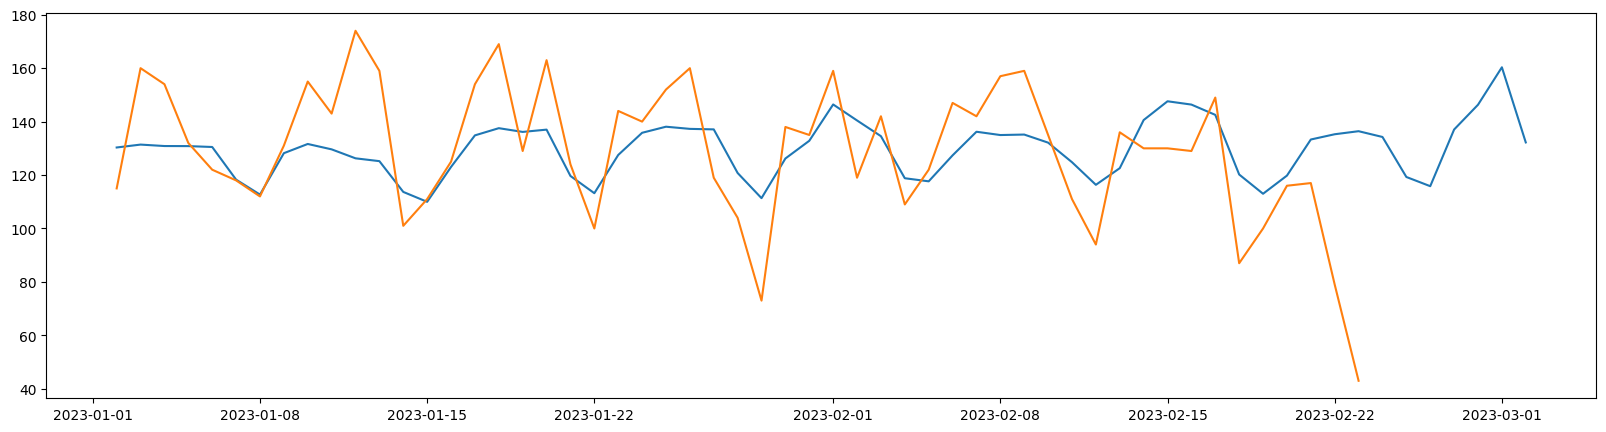

In [30]:
item_id = 'Crimes'
y_past = train_data.loc[item_id]['target']
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]['target'][-53:]

plt.figure(figsize=(20, 5))

# plt.plot(y_past, label='Past time series values')
plt.plot(y_pred['mean'], label='Mean forecast')
plt.plot(y_test, label='Future time series values')